# Flatfield calibration

Inspiration from: https://scripts.iucr.org/cgi-bin/paper?S1600577523001157

Work done for ID31: Scattering of amorphous carbon on a well defined position using a Pilatus CdTe 2M.

There are 9 positions investigated on the detector each of them contains calibration data and a flatfield image.
First of all define an object container containing position, calibration, ...

In [1]:
%matplotlib inline
# Switch from widget <-> inline for documentation purposes
import copy, time
from dataclasses import dataclass
import numpy
import h5py
from matplotlib.pyplot import subplots
import fabio
from silx.resources import ExternalResources
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
from pyFAI.gui.cli_calibration import AbstractCalibration

t0 = time.perf_counter()
print(f"Running pyFAI version {pyFAI.version}")

Running pyFAI version 2025.5.0-dev0


In [2]:
polarization = 0.999
npt = 512
energy = 75 #keV
wavelength = 1e-10*pyFAI.units.hc/energy
detector = pyFAI.detector_factory("Pilatus2M_CdTe")
calibrant = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
calibrant.wavelength = wavelength

In [3]:
# Here we download the test data

downloader = ExternalResources("flatfield", "http://www.silx.org/pub/pyFAI/testimages")
all_files = downloader.getdir("flatfield_ID31.tar.bz2")
master_file = [i for i in all_files if i.endswith("calibration_0001.h5")][0]
print(master_file)

/tmp/flatfield_testdata_jerome/flatfield_ID31.tar.bz2__content/flatfield_ID31/calibration_0001.h5


In [4]:
@dataclass
class Position:
    """All data related to one of the position"""    
    position: int
    calibration_idx: int
    scattering_idx: int
    coordinates: tuple=tuple()
    calibration_data: object=None
    scattering_data: object=None
    poni: object=None
    ai: object=None
    control_points: object=None
    flatfield: object=None
    
    @classmethod
    def init(cls, h5_file, position, calibration_idx, scattering_idx, detector_name="p3", positioners=("cncx","cncy","cncz")):
        with h5py.File(h5_file) as h:
            calibration_str = f"{calibration_idx}."
            scattering_str = f"{scattering_idx}."
            keys = list(h.keys())
            ids = [i for i in keys if i.startswith(calibration_str)]
            if ids:
                entry = h[ids[0]]
                calibration_data = entry[f"measurement/{detector_name}"][0]
                coordinates = tuple(entry[f"instrument/positioners/{positioner}"][()] for positioner in positioners)
            else:
                raise IndexError(f"no such Entry {calibration_idx}")
            ids = [i for i in keys if i.startswith(scattering_str)]
            if ids:
                entry = h[ids[0]]
                scattering_data = entry[f"measurement/{detector_name}"][0]
                coordinates = tuple(entry[f"instrument/positioners/{positioner}"][()] for positioner in positioners)
            else:
                raise IndexError(f"no such Entry {calibration_idx}")
        return cls(position, calibration_idx, scattering_idx, coordinates, calibration_data, scattering_data)
            
center = Position.init(master_file, "CC", 14, 13)
center

Position(position='CC', calibration_idx=14, scattering_idx=13, coordinates=(np.float64(6489.605), np.float64(20.0), np.float64(20.0)), calibration_data=array([[2728, 2784, 2791, ..., 1582, 1636, 1544],
       [2664, 2663, 2829, ..., 1542, 1485, 1533],
       [2839, 2739, 2674, ..., 1542, 1581, 1478],
       ...,
       [3216, 2998, 3165, ..., 3048, 2992, 3125],
       [3121, 3252, 3299, ..., 3086, 3110, 2913],
       [3231, 3261, 3414, ..., 3099, 3039, 3020]],
      shape=(1679, 1475), dtype=int32), scattering_data=array([[102929, 101856, 105155, ...,  36466,  36234,  35175],
       [100320,  98901, 104158, ...,  35047,  34531,  35871],
       [102334, 101772,  98380, ...,  35634,  35428,  34703],
       ...,
       [ 96866,  94780,  96978, ...,  95870,  94463,  97045],
       [ 97101,  99105,  99604, ...,  97634,  97246,  94603],
       [100027,  99620, 102607, ...,  95336,  96377,  94539]],
      shape=(1679, 1475), dtype=int32), poni=None, ai=None, control_points=None, flatfield=Non

In [5]:
# This contains which scan correspond to what position and if it contains amorphous scattering or calibration data.
data =[None,
       Position.init(master_file, 1, 1, 5),
       Position.init(master_file, 2, 7, 6),
       Position.init(master_file, 3, 8, 9),
       Position.init(master_file, 4, 11, 12),
       Position.init(master_file, 5, 14, 13),
       Position.init(master_file, 6, 15, 16),
       Position.init(master_file, 7, 18, 17),
       Position.init(master_file, 8, 19, 20),
       Position.init(master_file, 9, 22, 21)]

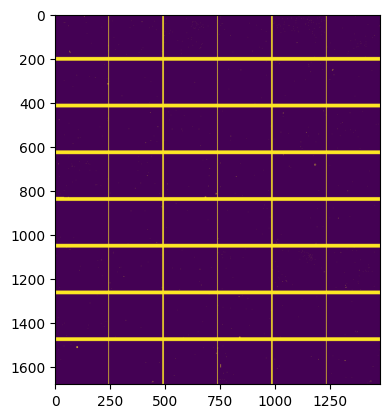

In [6]:
#calculate the mask:

mask = -detector.mask.astype(int)
for p in data[1:]:
    numpy.minimum(mask, p.scattering_data, out=mask)
    numpy.minimum(mask, p.calibration_data, out=mask)
detector.mask = (mask<0).astype(numpy.int8)
fig, ax = subplots()
ax.imshow(detector.mask)

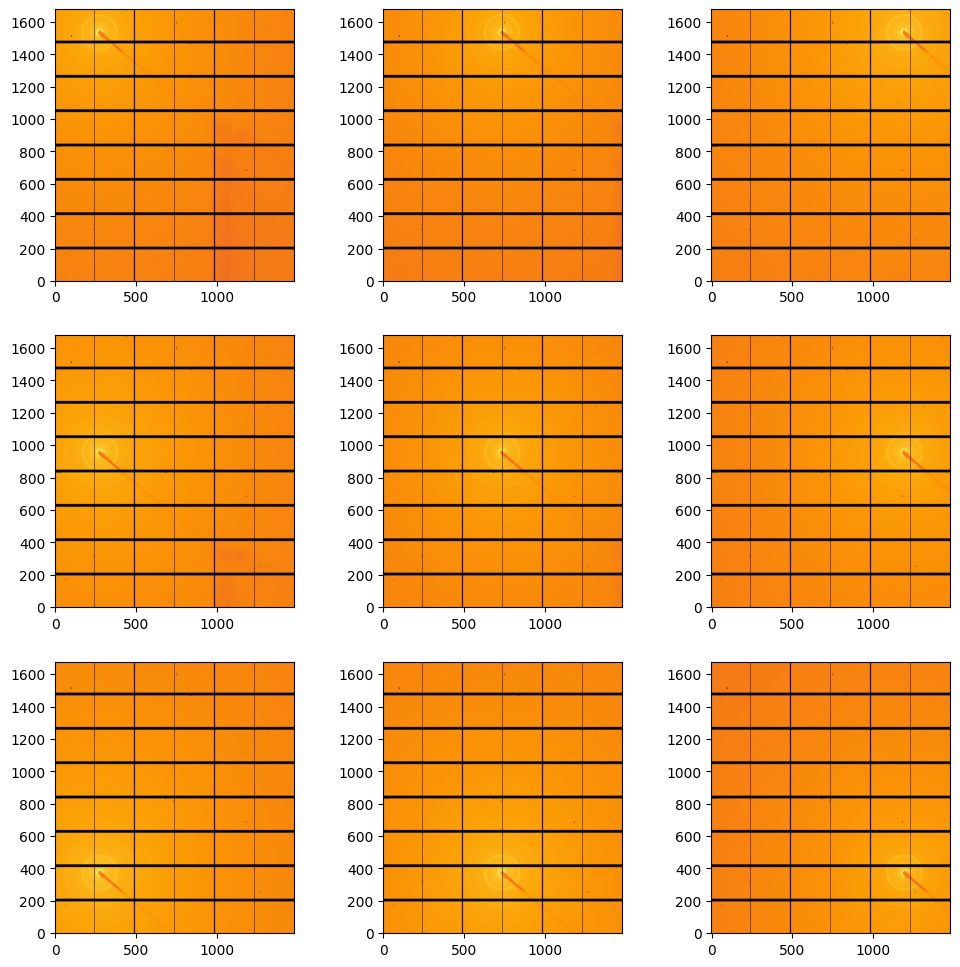

In [7]:
#display calibraation scattering:
fig, ax = subplots(3,3, figsize=(12,12))
jupyter.display(data[1].calibration_data, ax=ax[0,2])
jupyter.display(data[2].calibration_data, ax=ax[0,1])
jupyter.display(data[3].calibration_data, ax=ax[0,0])
jupyter.display(data[4].calibration_data, ax=ax[1,0])
jupyter.display(data[5].calibration_data, ax=ax[1,1])
jupyter.display(data[6].calibration_data, ax=ax[1,2])
jupyter.display(data[7].calibration_data, ax=ax[2,2])
jupyter.display(data[8].calibration_data, ax=ax[2,1])
jupyter.display(data[9].calibration_data, ax=ax[2,0])
pass

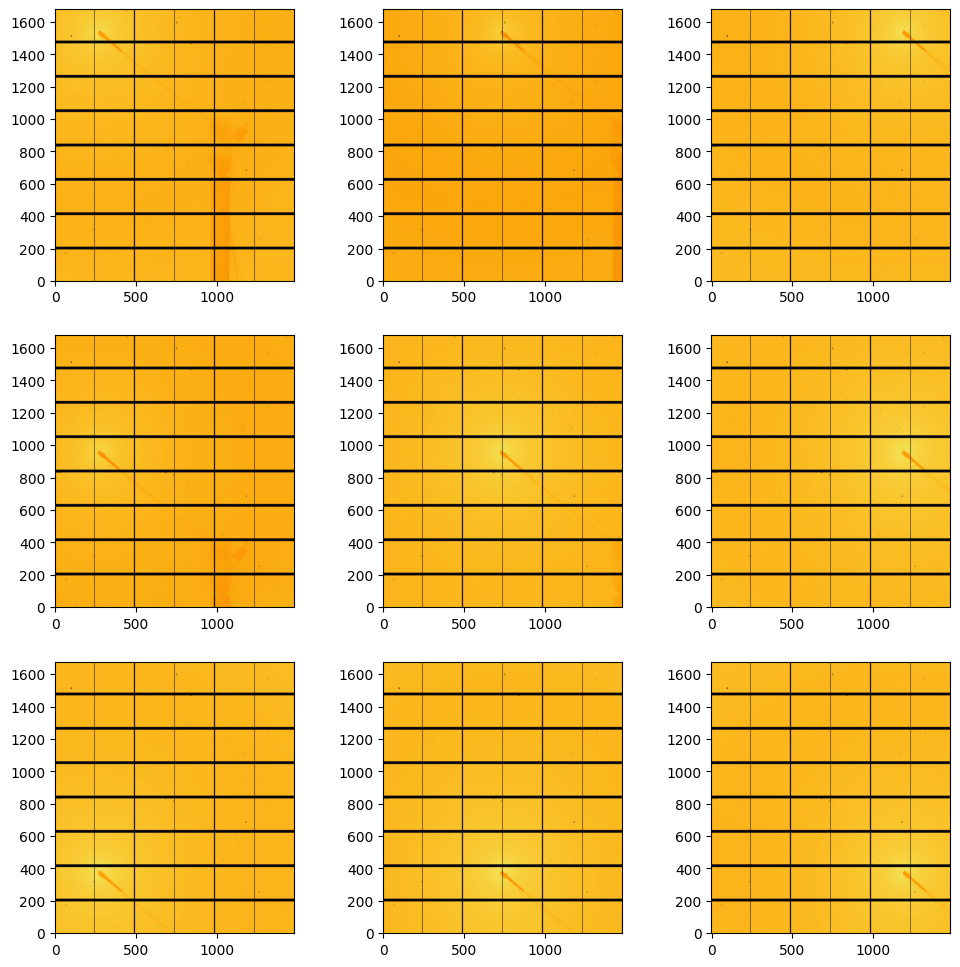

In [8]:
#display amorphous scattering:
fig, ax = subplots(3,3, figsize=(12,12))
jupyter.display(data[1].scattering_data, ax=ax[0,2])
jupyter.display(data[2].scattering_data, ax=ax[0,1])
jupyter.display(data[3].scattering_data, ax=ax[0,0])
jupyter.display(data[4].scattering_data, ax=ax[1,0])
jupyter.display(data[5].scattering_data, ax=ax[1,1])
jupyter.display(data[6].scattering_data, ax=ax[1,2])
jupyter.display(data[7].scattering_data, ax=ax[2,2])
jupyter.display(data[8].scattering_data, ax=ax[2,1])
jupyter.display(data[9].scattering_data, ax=ax[2,0])
pass

## Calibration of the central position

In [10]:
%matplotlib widget
extra_mask = center.calibration_data<5000
# switch to widget mode ... for calibration purpose. Use right click.
calib = Calibration(center.calibration_data, 
                    calibrant=calibrant, 
                    wavelength=calibrant.wavelength,
                    detector=copy.deepcopy(detector),
                    mask=extra_mask)  # Mind the mask option mangles the detector's mask ! 

Please perform the calibration in the previous cell before going on ... use the right-click 


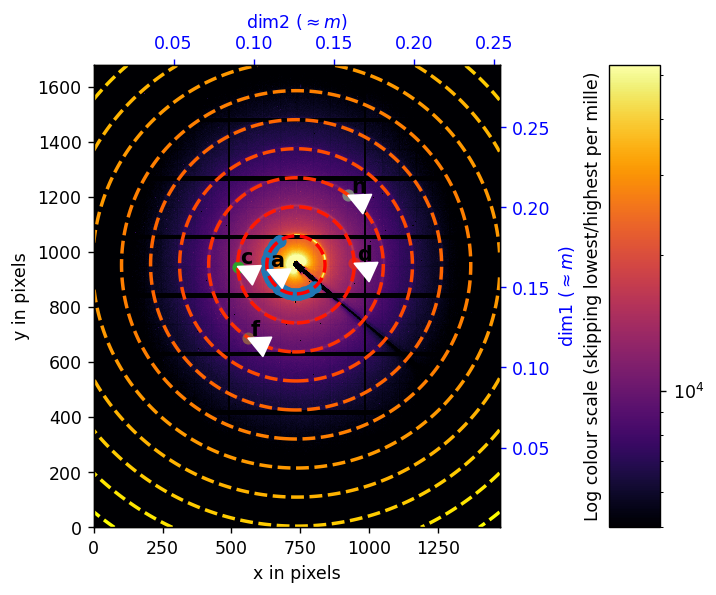

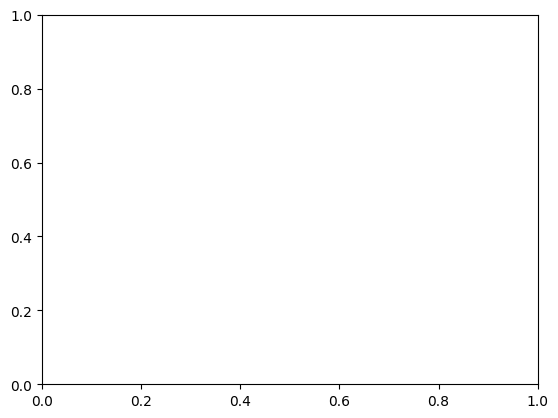

In [11]:
input("Please perform the calibration in the previous cell before going on ... use the right-click")
%matplotlib inline
fig, ax = subplots()

In [12]:
calib.mask=None
print(calib.geoRef)
f2d = calib.geoRef.getFit2D()
f2d["tilt"] = 0
calib.geoRef.setFit2D(**f2d)
print(calib.geoRef)
calib.fixed += ["rot1", "rot2"]
print(f"Fixed parameters: {calib.fixed}")

Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.386680e+00 m	PONI= 1.981606e-01, -3.307941e-01 m	rot1=-0.071465  rot2=-0.005316  rot3=0.000000 rad
DirectBeamDist= 6403.114 mm	Center: x=734.932, y=954.212 pix	Tilt= 4.106° tiltPlanRotation= -4.257° 𝛌= 0.165Å
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.403114e+00 m	PONI= 1.641245e-01, 1.264083e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6403.114 mm	Center: x=734.932, y=954.212 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å
Fixed parameters: ['wavelength', 'rot3', 'rot1', 'rot2']


In [13]:
logger = pyFAI.gui.cli_calibration.logger
from silx.image import marchingsquares
def extract_cpt(self, method="massif", pts_per_deg=1.0, max_rings=numpy.iinfo(int).max):
        """
        Performs an automatic keypoint extraction:
        Can be used in recalib or in calib after a first calibration has been performed.

        :param method: method for keypoint extraction
        :param pts_per_deg: number of control points per azimuthal degree (increase for better precision)
        :param max_rings: extract at most max_rings
        """
        
        logger.info("in extract_cpt with method %s", method)
        assert self.ai
        assert self.calibrant
        assert self.peakPicker
        self.peakPicker.reset()
        self.peakPicker.init(method, False)
        if self.geoRef:
            self.ai.setPyFAI(**self.geoRef.getPyFAI())
        tth = numpy.array([i for i in self.calibrant.get_2th() if i is not None])
        tth = numpy.unique(tth)
        tth_min = numpy.zeros_like(tth)
        tth_max = numpy.zeros_like(tth)
        delta = (tth[1:] - tth[:-1]) / 4.0
        tth_max[:-1] = delta
        tth_max[-1] = delta[-1]
        tth_min[1:] = -delta
        tth_min[0] = -delta[0]
        tth_max += tth
        tth_min += tth

        if self.geoRef:
            ttha = self.geoRef.get_ttha()
            chia = self.geoRef.get_chia()
            if (ttha is None) or (ttha.shape != self.peakPicker.data.shape):
                ttha = self.geoRef.twoThetaArray(self.peakPicker.data.shape)
            if (chia is None) or (chia.shape != self.peakPicker.data.shape):
                chia = self.geoRef.chiArray(self.peakPicker.data.shape)
        else:
            ttha = self.ai.twoThetaArray(self.peakPicker.data.shape)
            chia = self.ai.chiArray(self.peakPicker.data.shape)
        rings = 0
        self.peakPicker.sync_init()
        if self.max_rings is None:
            self.max_rings = tth.size

        ms = marchingsquares.MarchingSquaresMergeImpl(ttha, self.mask, use_minmax_cache=True)
        for i in range(tth.size):
            if rings >= min(self.max_rings, max_rings):
                break
            mask1 = numpy.logical_and(ttha >= tth_min[i], ttha < tth_max[i])
            if self.mask is not None:
                numpy.logical_and(mask1, numpy.logical_not(self.mask), out=mask1)
                
            size = mask1.sum(dtype=int)
            if (size > 0):
                rings += 1
                self.peakPicker.massif_contour(mask1)
                # if self.gui:
                #     self.peakPicker.widget.update()
                sub_data = self.peakPicker.data.ravel()[numpy.where(mask1.ravel())]
                mean = sub_data.mean(dtype=numpy.float64)
                std = sub_data.std(dtype=numpy.float64)
                upper_limit = mean + std
                mask2 = numpy.logical_and(self.peakPicker.data > upper_limit, mask1)
                size2 = mask2.sum(dtype=int)
                if size2 < 1000:
                    upper_limit = mean
                    numpy.logical_and(self.peakPicker.data > upper_limit, mask1, out=mask2)
                    size2 = mask2.sum()
                # length of the arc:
                points = ms.find_pixels(tth[i])
                seeds = set((i[0], i[1]) for i in points if mask2[i[0], i[1]])
                # max number of points: 360 points for a full circle
                azimuthal = chia[points[:, 0].clip(0, self.peakPicker.data.shape[0]), points[:, 1].clip(0, self.peakPicker.data.shape[1])]
                nb_deg_azim = numpy.unique(numpy.rad2deg(azimuthal).round()).size
                keep = int(nb_deg_azim * pts_per_deg)
                if keep == 0:
                    continue
                dist_min = len(seeds) / 2.0 / keep
                # why 3.0, why not ?

                logger.info("Extracting datapoint for ring %s (2theta = %.2f deg); "
                            "searching for %i pts out of %i with I>%.1f, dmin=%.1f" %
                            (i, numpy.degrees(tth[i]), keep, size2, upper_limit, dist_min))
                _res = self.peakPicker.peaks_from_area(mask=mask2, Imin=upper_limit, keep=keep, method=method, ring=i, dmin=dist_min, seed=seeds)

        if self.basename:
            self.peakPicker.points.save(self.basename + ".npt")
        if self.weighted:
            self.data = self.peakPicker.points.getWeightedList(self.peakPicker.data)
        else:
            self.data = self.peakPicker.points.getList()
        if self.geoRef:
            self.geoRef.data = numpy.array(self.data, dtype=numpy.float64)
Calibration.extract_cpt = extract_cpt

In [15]:
calib.extract_cpt(max_rings=4)

In [16]:
calib.refine()

Before refinement, the geometry is:
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.403114e+00 m	PONI= 1.641245e-01, 1.264083e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6403.114 mm	Center: x=734.932, y=954.212 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.419204e+00 m	PONI= 1.641450e-01, 1.264146e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6419.204 mm	Center: x=734.969, y=954.332 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.419204e+00 m	PONI= 1.641450e-01, 1.264146e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6419.204 mm	Center: x=734.969, y=954.332 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


In [17]:
ai = calib.geoRef.promote("pyFAI.integrator.azimuthal.AzimuthalIntegrator")
it = ai.integrate1d(center.scattering_data, npt, polarization_factor=polarization, error_model="no", method=("no", "csr", "cython"))
sc = ai.sigma_clip(center.scattering_data, npt, polarization_factor=polarization, error_model="azimuthal", method=("no", "csr", "cython"),
                  thres=0, max_iter=3)
md = ai.medfilt1d_ng(center.scattering_data, npt, polarization_factor=polarization, method=("full", "csr", "cython"))

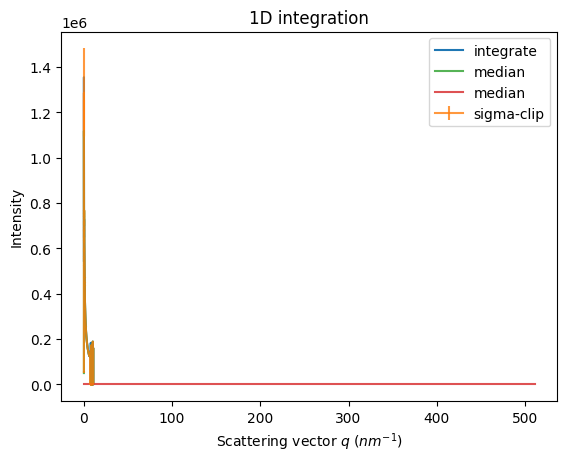

In [18]:
fig, ax = subplots()
ax = jupyter.plot1d(it, label="integrate", ax=ax)
ax.errorbar(*sc, alpha=0.8, label="sigma-clip")
ax.plot(*md, alpha=0.8, label="median")
ax.legend()

In [19]:
# Approximate polarization correction needed:
print(f"Approximate polarization factor: {ai.guess_polarization(center.scattering_data, unit='q_nm^-1', target_rad=10):.4f}")

Approximate polarization factor: 1.0000


/tmp/ipykernel_4156161/625551917.py:7: RuntimeWarning: divide by zero encountered in divide
  flat = rebuilt/center.scattering_data


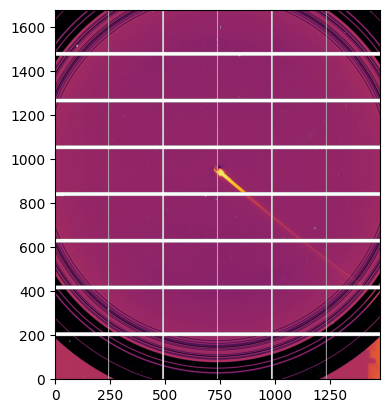

In [20]:
# median filter provides the smoothest curve achievable
rebuilt = ai.calcfrom1d(md.radial, 
                        md.intensity, 
                        detector.shape, 
                        dim1_unit=pyFAI.units.Q_NM, 
                        polarization_factor=polarization)
flat = rebuilt/center.scattering_data
flat[numpy.where(detector.mask)] = numpy.nan
flat[center.scattering_data<=0] = numpy.nan
jupyter.display(flat);

## Calculate the approximate correction of the other positions 

In [21]:
dx,dy,dz = numpy.array(data[1].coordinates)-center.coordinates
ai1 = copy.copy(ai)
ai1.poni1 += dz*0.001
ai1.poni2 += dy*0.001
ai1

Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.419204e+00 m	PONI= 2.641450e-01, 2.051546e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6419.204 mm	Center: x=1192.759, y=1535.727 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å

In [22]:
AbstractCalibration.extract_cpt = extract_cpt

In [23]:
calib1 = AbstractCalibration(data[1].calibration_data, detector.mask, detector, wavelength=wavelength, calibrant=calibrant)
calib1.preprocess()
calib1.data = []
calib1.geoRef = calib1.initgeoRef()
calib1.geoRef.setPyFAI(**ai1.getPyFAI())

Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.419204e+00 m	PONI= 2.641450e-01, 2.051546e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6419.204 mm	Center: x=1192.759, y=1535.727 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å

In [24]:
calib1.extract_cpt(max_rings=4)

ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


In [25]:
calib1.fixed+=["rot1", "rot2"]
calib1.geoRef.refine3(fix=calib1.fixed)

np.float64(3.9347065301144453e-10)

In [26]:
calib1.geoRef

Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.432287e+00 m	PONI= 2.640874e-01, 2.050781e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6432.287 mm	Center: x=1192.314, y=1535.392 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å

In [27]:
data[1].ai = pyFAI.load(calib1.geoRef)
data[1].control_points = calib1.peakPicker.points
data[5].ai = pyFAI.load(calib.geoRef)
data[5].control_points = calib.peakPicker.points

## Perform the geometry extraction for each of the position:

In [28]:
for idx in [2,3,4,6,7,8,9]:
    dx,dy,dz = numpy.array(data[idx].coordinates)-center.coordinates
    ain = copy.copy(ai)
    ain.poni1 += dz*0.001
    ain.poni2 += dy*0.001
    calibn = AbstractCalibration(data[idx].calibration_data, detector.mask, detector, wavelength=wavelength, calibrant=calibrant)
    calibn.preprocess()
    calibn.data = []
    calibn.geoRef = calib1.initgeoRef()
    calibn.geoRef.setPyFAI(**ain.getPyFAI())
    calibn.extract_cpt(max_rings=4)
    calibn.fixed+=["rot1", "rot2"]
    calibn.geoRef.refine3(fix=calibn.fixed)
    print(f"#### Position {idx} ####")
    print(calibn.geoRef)
    data[idx].ai = pyFAI.load(calibn.geoRef)
    data[idx].control_points = calibn.peakPicker.points

ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 2 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.433144e+00 m	PONI= 2.640908e-01, 1.262894e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6433.144 mm	Center: x=734.241, y=1535.411 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 3 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.432473e+00 m	PONI= 2.640263e-01, 4.749531e-02 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6432.473 mm	Center: x=276.136, y=1535.037 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 4 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.433286e+00 m	PONI= 1.641177e-01, 4.762946e-02 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6433.286 mm	Center: x=276.915, y=954.173 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 6 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.433113e+00 m	PONI= 1.641411e-01, 2.051786e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6433.113 mm	Center: x=1192.899, y=954.309 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 7 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.433902e+00 m	PONI= 6.420702e-02, 2.052248e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6433.902 mm	Center: x=1193.168, y=373.297 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 8 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.435118e+00 m	PONI= 6.413713e-02, 1.264374e-01 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6435.118 mm	Center: x=735.101, y=372.890 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour
ERROR:root:No diffraction image available => not showing the contour


#### Position 9 ####
Detector Pilatus CdTe 2M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.653123e-11 m
SampleDetDist= 6.434564e+00 m	PONI= 6.412588e-02, 4.770209e-02 m	rot1=0.000000  rot2=-0.000000  rot3=0.000000 rad
DirectBeamDist= 6434.564 mm	Center: x=277.338, y=372.825 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.165Å


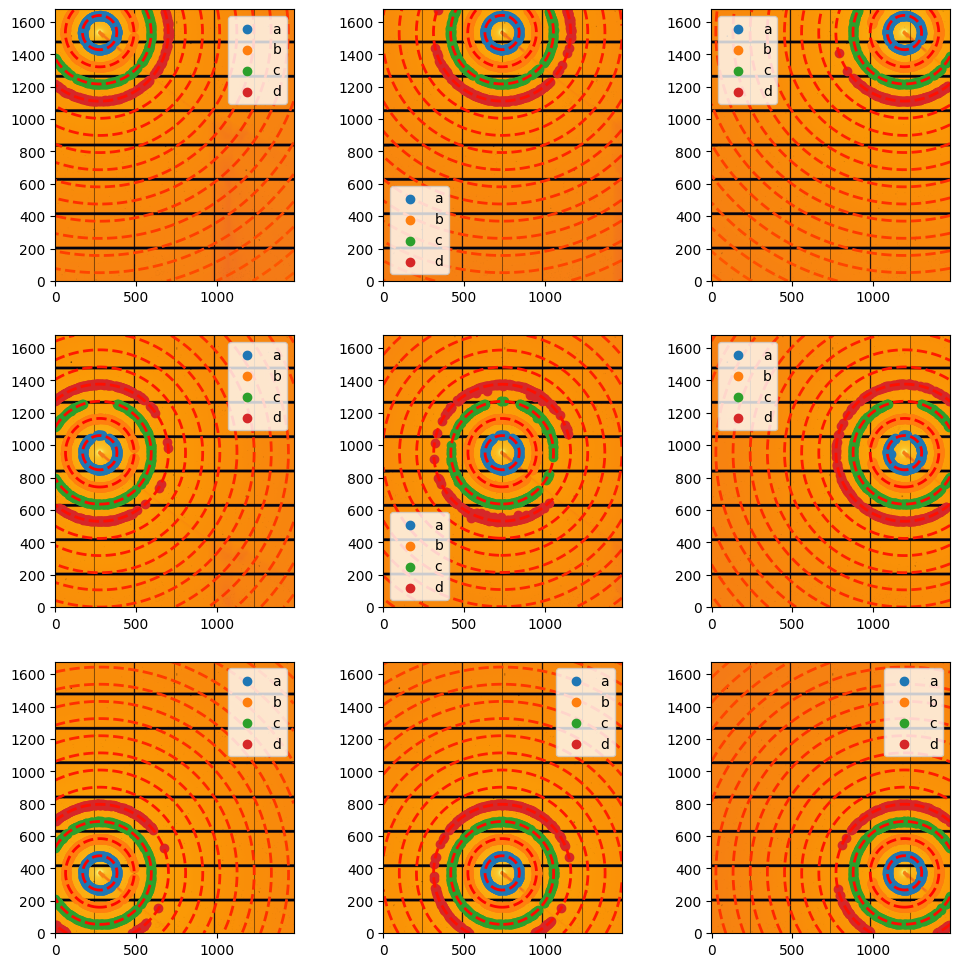

In [29]:
#display scattering:
fig, ax = subplots(3,3, figsize=(12,12))
jupyter.display(data[1].calibration_data, ai=data[1].ai, cp=data[1].control_points, ax=ax[0,2])
jupyter.display(data[2].calibration_data, ai=data[2].ai, cp=data[2].control_points, ax=ax[0,1])
jupyter.display(data[3].calibration_data, ai=data[3].ai, cp=data[3].control_points, ax=ax[0,0])
jupyter.display(data[4].calibration_data, ai=data[4].ai, cp=data[4].control_points, ax=ax[1,0])
jupyter.display(data[5].calibration_data, ai=data[5].ai, cp=data[5].control_points, ax=ax[1,1])
jupyter.display(data[6].calibration_data, ai=data[6].ai, cp=data[6].control_points, ax=ax[1,2])
jupyter.display(data[7].calibration_data, ai=data[7].ai, cp=data[7].control_points, ax=ax[2,2])
jupyter.display(data[8].calibration_data, ai=data[8].ai, cp=data[8].control_points, ax=ax[2,1])
jupyter.display(data[9].calibration_data, ai=data[9].ai, cp=data[9].control_points, ax=ax[2,0])
pass

## Extract the flatfield for all positions

In [30]:
for p in data[1:]:
    md = p.ai.medfilt1d_ng(p.scattering_data, npt, polarization_factor=polarization, method=("full", "csr", "cython"))
    rebuilt = p.ai.calcfrom1d(md.radial, md.intensity, detector.shape, dim1_unit=pyFAI.units.Q_NM, polarization_factor=polarization)
    flat = rebuilt/p.scattering_data
    flat[numpy.where(detector.mask)] = numpy.nan
    flat[p.scattering_data<=0] = numpy.nan
    p.flat = flat

/tmp/ipykernel_4156161/1355855140.py:4: RuntimeWarning: divide by zero encountered in divide
  flat = rebuilt/p.scattering_data


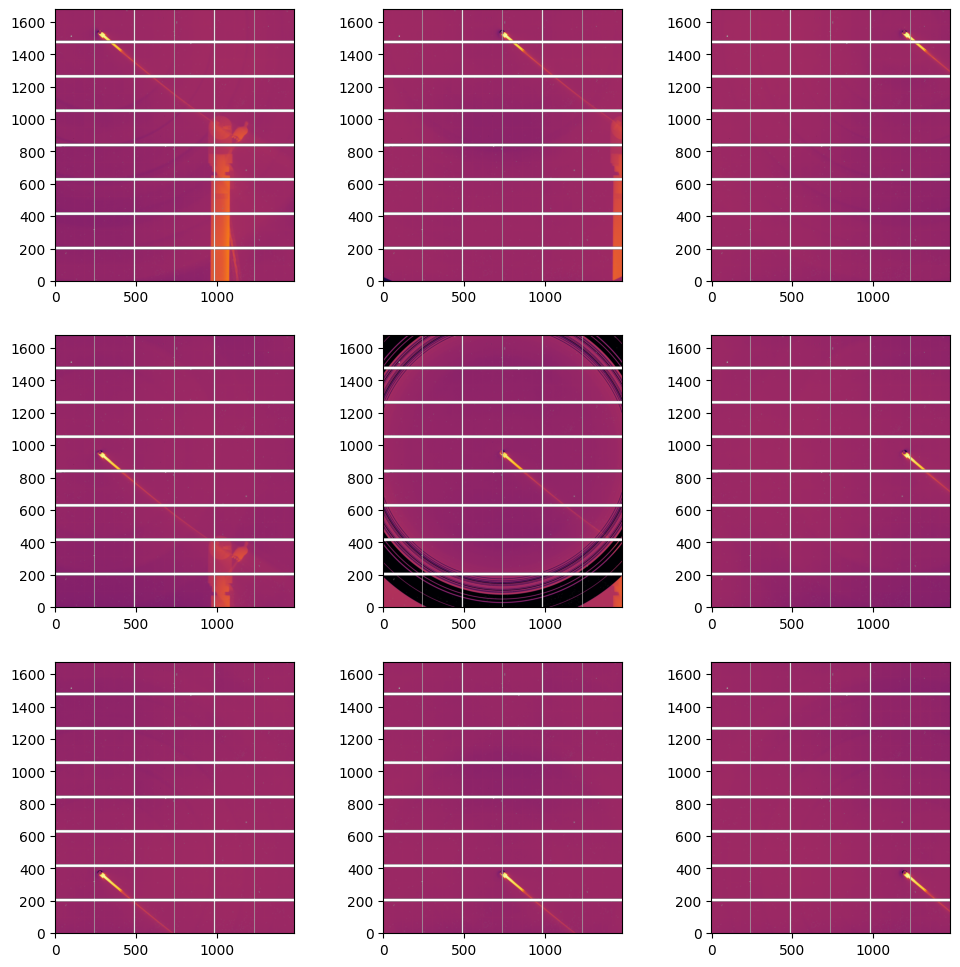

In [31]:
#display flat:
fig, ax = subplots(3,3, figsize=(12,12))
jupyter.display(data[1].flat, ax=ax[0,2])
jupyter.display(data[2].flat, ax=ax[0,1])
jupyter.display(data[3].flat, ax=ax[0,0])
jupyter.display(data[4].flat, ax=ax[1,0])
jupyter.display(data[5].flat, ax=ax[1,1])
jupyter.display(data[6].flat, ax=ax[1,2])
jupyter.display(data[7].flat, ax=ax[2,2])
jupyter.display(data[8].flat, ax=ax[2,1])
jupyter.display(data[9].flat, ax=ax[2,0])
pass

## The final Flatfield is the median of the flats calculated on the 9 positions

In [32]:
flat_stack = numpy.array([p.flat for p in data[1:]])
flat = numpy.nanmedian(flat_stack, axis=0)

/tmp/ipykernel_4156161/4120576390.py:2: RuntimeWarning: All-NaN slice encountered
  flat = numpy.nanmedian(flat_stack, axis=0)


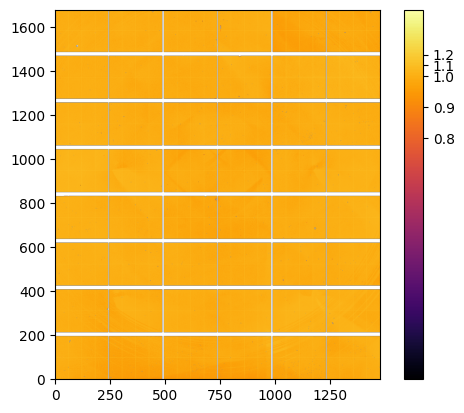

In [33]:
ax = jupyter.display(flat)
cb = ax.figure.colorbar(ax.images[0]);
pos = numpy.linspace(0.8,1.2, 5)
ticks = [str(i) for i in pos]
cb.set_ticks(pos, labels=ticks);

In [34]:
fabio.edfimage.EdfImage(data=flat.astype("float32")).write("flat.edf")

In [35]:
print(f"Total run time: {time.perf_counter()-t0:.3f}s.")

Total run time: 174.956s.
